# MLP ORF to GenCode 

Use GenCode 38 and length-restricted data.  
Use model pre-trained on Simulated ORF.  

In [1]:
import time
def show_time():
    t = time.time()
    print(time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t)))
show_time()

2021-08-18 09:58:48 EDT


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import Flatten,TimeDistributed
from keras.losses import BinaryCrossentropy
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

2021-08-18 09:58:49.316801: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:
import sys
IN_COLAB = False
try:
    from google.colab import drive
    IN_COLAB = True
except:
    pass
if IN_COLAB:
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
        f.write(r.text)  
    from RNA_describe import ORF_counter
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/GenCodeTools.py')
    with open('GenCodeTools.py', 'w') as f:
        f.write(r.text)  
    from GenCodeTools import GenCodeLoader
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/KmerTools.py')
    with open('KmerTools.py', 'w') as f:
        f.write(r.text)  
    from KmerTools import KmerTools
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/DataPrep.py')
    with open('DataPrep.py', 'w') as f:
        f.write(r.text)  
    from DataPrep import DataPrep
else:
        print("CoLab not working. On my PC, use relative paths.")
        DATAPATH='data/'  # must end in "/"
        sys.path.append("..") # append parent dir in order to use sibling dirs
        from SimTools.RNA_describe import ORF_counter
        from SimTools.GenCodeTools import GenCodeLoader
        from SimTools.KmerTools import KmerTools
        from SimTools.DataPrep import DataPrep
BESTMODELPATH=DATAPATH+"BestModel-304"  
LASTMODELPATH=DATAPATH+"LastModel"  

CoLab not working. On my PC, use relative paths.


## Data Load

In [4]:
PC_TRAINS=1000
NC_TRAINS=1000
PC_TESTS=40000
NC_TESTS=40000   
PC_LENS=(200,4000)
NC_LENS=(200,4000)   # Wen used 3500 for hyperparameter, 3000 for train
PC_FILENAME='gencode.v38.pc_transcripts.fa.gz'
NC_FILENAME='gencode.v38.lncRNA_transcripts.fa.gz'
PC_FULLPATH=DATAPATH+PC_FILENAME
NC_FULLPATH=DATAPATH+NC_FILENAME
MAX_K = 3 
INPUT_SHAPE=(None,84)  # 4^3 + 4^2 + 4^1
NEURONS=32
DROP_RATE=0.30
EPOCHS=200
SPLITS=3
FOLDS=3   
show_time()

2021-08-18 09:58:49 EDT


In [5]:
loader=GenCodeLoader()
loader.set_label(1)
loader.set_check_utr(False)  # not ORF-restricted
loader.set_check_size(*PC_LENS)   # length-restricted
pcdf=loader.load_file(PC_FULLPATH)
print("PC seqs loaded:",len(pcdf))
loader.set_label(0)
loader.set_check_utr(False)   
loader.set_check_size(*NC_LENS) # length-restricted
ncdf=loader.load_file(NC_FULLPATH)
print("NC seqs loaded:",len(ncdf))
show_time()

PC seqs loaded: 88964
NC seqs loaded: 46919
2021-08-18 09:58:51 EDT


In [6]:
def dataframe_extract_sequence(df):
    return df['sequence'].tolist()

pc_all = dataframe_extract_sequence(pcdf)
nc_all = dataframe_extract_sequence(ncdf)
pcdf=None
ncdf=None

show_time()
print("PC seqs pass filter:",len(pc_all),type(pc_all))
print("NC seqs pass filter:",len(nc_all),type(nc_all))

#PC seqs pass filter: 55381
#NC seqs pass filter: 46919

2021-08-18 09:58:51 EDT
PC seqs pass filter: 88964 <class 'list'>
NC seqs pass filter: 46919 <class 'list'>


In [7]:
print("Simulated sequence characteristics:")
oc = ORF_counter()
print("PC seqs")
oc.describe_sequences(pc_all)
print("NC seqs")
oc.describe_sequences(nc_all)
oc=None
show_time()

Simulated sequence characteristics:
PC seqs
Average RNA length: 1546.957241131244
Average ORF length: 785.6919203273234
NC seqs
Average RNA length: 1179.5947483961722
Average ORF length: 203.12651591039878
2021-08-18 09:59:09 EDT


## Data Prep

In [8]:
dp = DataPrep()
Xseq,y=dp.combine_pos_and_neg(pc_all,nc_all)
nc_all=None
pc_all=None
nc_all=None
print("The first few shuffled labels:")
print(y[:30])
show_time()

The first few shuffled labels:
[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1]
2021-08-18 09:59:09 EDT


In [9]:
Xfrq=KmerTools.seqs_to_kmer_freqs(Xseq,MAX_K)
Xseq = None
y=np.asarray(y)
show_time()

2021-08-18 09:59:45 EDT


In [10]:
# Assume X and y were shuffled.
train_size=PC_TRAINS+NC_TRAINS
X_train=Xfrq[:train_size] 
X_test=Xfrq[train_size:]
y_train=y[:train_size] 
y_test=y[train_size:]
print("Training set size=",len(X_train),"=",len(y_train))
print("Reserved test set size=",len(X_test),"=",len(y_test))
Xfrq=None
y=None
show_time()

Training set size= 2000 = 2000
Reserved test set size= 133883 = 133883
2021-08-18 09:59:45 EDT


## Load a trained neural network

In [11]:
show_time()
model = load_model(BESTMODELPATH)
print(model.summary())

2021-08-18 09:59:45 EDT
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                2720      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (

2021-08-18 09:59:45.831390: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-18 09:59:45.852590: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-18 09:59:45.852866: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2021-08-18 09:59:45.852886: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-18 09:59:45.854796: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-18 09:59:45.854827: I tensorflow/stream_executor

## Test the neural network

In [12]:
def show_test_AUC(model,X,y):
    ns_probs = [0 for _ in range(len(y))]
    bm_probs = model.predict(X)
    ns_auc = roc_auc_score(y, ns_probs)
    bm_auc = roc_auc_score(y, bm_probs)
    ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
    bm_fpr, bm_tpr, _ = roc_curve(y, bm_probs)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess, auc=%.4f'%ns_auc)
    plt.plot(bm_fpr, bm_tpr, marker='.', label='Model, auc=%.4f'%bm_auc)
    plt.title('ROC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    print("%s: %.2f%%" %('AUC',bm_auc*100.0))
def show_test_accuracy(model,X,y):
    scores = model.evaluate(X, y, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


Accuracy on test data.
2021-08-18 09:59:46 EDT


2021-08-18 09:59:46.417076: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-18 09:59:46.435699: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2496000000 Hz
2021-08-18 09:59:48.575297: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-18 09:59:48.894578: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


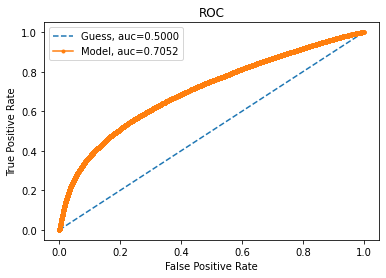

AUC: 70.52%
accuracy: 65.20%
2021-08-18 09:59:53 EDT


In [13]:
print("Accuracy on test data.")
show_time()
show_test_AUC(model,X_test,y_test)
show_test_accuracy(model,X_test,y_test)
show_time()